In [1]:
"""
 
  Copyright (C) 2024 Yun-Peng Li, Hans-Andrea Loeliger.
 
  Date: 2024-2-13
  Author: Yunpeng Li (yunpli@isi.ee.ethz.ch)
  Brief: Performing MAP estimation for linear non-Gaussian state space models using
         BFFD (backward filtering forward deciding) algorithm. Two demos in papers
         are given:
             1). regression with non-Gaussian inputs on 'global warming datasets'.
             2). linear quadratic constrained control for two dimensional object moving.
  Cite: Y.-P Li, H.-A. Loeliger, “Backward Filtering Forward Deciding in Linear Non-Gaussian 
         State Space Models,” (to be appeared) in 2024 International Conference on Artificial 
         Intelligence and Statistics (AISTATS2024), May 2024.
  Dependence:---python
                   ---- numpy
                   ---- matplotlib
                   ---- cython
             ---C
                   ---- clbas
                   ---- clapack
  
  Complie:
          ---C
          
          cc -Wall -g -O -fPIC -c utils.c -o utils.o 
          cc -Wall -g -O -fPIC -c bffd_smoothing.c -o bffd_smoothing.o
          cc -shared -o libnup4ssm.so *.o  -lcblas -lblas -llapack
          
          ---cython
          
          export LD_LIBRARY_PATH=.:$LD_LIBRARY_PATH
          python setup.py build_ext --inplace
                    
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cython

In [2]:
from pyNUP4SSM import pyBFFD_input_estimation, pyBFFD_constrained_control

In [3]:
"""

regression with non-Gaussian inputs on 'global warming datasets'

"""

"\n\nregression with non-Gaussian inputs on 'global warming datasets'\n\n"

In [4]:



data = np.loadtxt('Land_Ocean_Temperature.txt',skiprows=1)
N = data.shape[0]
years = data[:,0]
y_obs = np.array(data[:,1][:,np.newaxis])

ks = [0,1]

beta_maxs = np.array([9.249999946219615,17.1988701570505],dtype=float)





As = [np.array([[1.]],dtype=float),np.array([[2.,-1.],[1.,0.]],dtype=float)]
Bs = [np.array([[1.]],dtype=float),np.array([[1.],[0.]],dtype=float)]
Cs = [np.array([[1.]],dtype=float),np.array([[0.,1.]],dtype=float)]


maxit = 200
ratios = [1e-4,1e-2,1.]


all_objs = np.zeros((2,3,maxit),dtype=float)
all_yests = np.zeros((2,3,N,1),dtype=float)
all_total_iters = np.zeros((2,3),dtype=float)


choice = 2
NUP_parameters = np.zeros((2,),dtype=float)







for k in range(2):
    
    A = As[k]
    B = Bs[k]
    C = Cs[k]

    
    M = A.shape[0]
    L = B.shape[1]
    K = C.shape[0]
    
    
    
    msgb_W_Yn = np.eye(K)
    msgf_Xi_X1 = np.zeros((M,),dtype=float)
    msgf_W_X1 = np.zeros((M,M),dtype=float)
    
    msgb_Xi_Xf = np.zeros((M,),dtype=float)
    msgb_W_Xf = np.zeros((M,M),dtype=float)

    
    beta_max = beta_maxs[k]
    max_valid_index = N-k-1

    
    for r in range(3):
        #beta = betas[r]
        beta = beta_max*ratios[r]
        #len_inputs = N;
        print("k = ",k, ", r = ",r, ", beta = ",beta)
        _,_,all_yests[k,r,:],all_objs[k,r,:],all_total_iters[k,r] = pyBFFD_input_estimation(choice,NUP_parameters,\
                                        beta,max_valid_index,A,B,C,y_obs,msgb_W_Yn, msgf_Xi_X1, msgf_W_X1,msgb_Xi_Xf,
                                        msgb_W_Xf,maxit)

        

k =  0 , r =  0 , beta =  0.0009249999946219615
k =  0 , r =  1 , beta =  0.09249999946219616
k =  0 , r =  2 , beta =  9.249999946219615
k =  1 , r =  0 , beta =  0.0017198870157050501
k =  1 , r =  1 , beta =  0.171988701570505
k =  1 , r =  2 , beta =  17.1988701570505


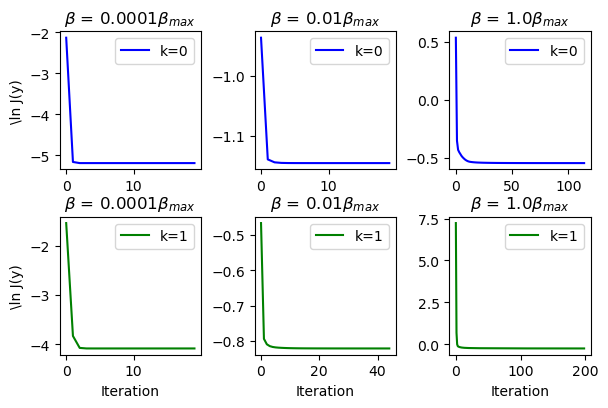

In [5]:
plt.figure(figsize=(6,4))
for nrow in range(2):
    for ncol in range(3):
        plt.subplot(2,3,nrow*3+ncol+1)
        plt.title(r"$\beta$ = {}".format(ratios[ncol]) + r"$\beta_{max}$")
        if(nrow==0):
            plt.plot(np.log(all_objs[0,ncol,:int(all_total_iters[0,ncol])]),color='blue',label='k=0')
        else:
            plt.plot(np.log(all_objs[1,ncol,:int(all_total_iters[1,ncol])]),color='green',label='k=1')
            plt.xlabel("Iteration")
        if(ncol==0):
            plt.ylabel(r"\ln J(y)")
        plt.legend()
plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.1)

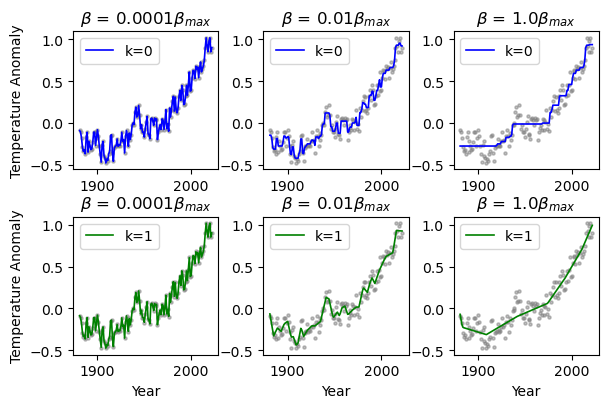

In [26]:
plt.figure(figsize=(6,4))
for nrow in range(2):
    for ncol in range(3):
        plt.subplot(2,3,nrow*3+ncol+1)
        plt.title(r"$\beta$ = {}".format(ratios[ncol]) + r"$\beta_{max}$")
        plt.scatter(years,y_obs[:,0],color='gray',alpha=0.5,s=5.)
        if(nrow==0):
            plt.plot(years,all_yests[0,ncol,:],color='blue',label='k=0',linewidth=1.2)
        else:
            plt.plot(years,all_yests[1,ncol,:],color='green',label='k=1',linewidth=1.2)
            plt.xlabel("Year")
        if(ncol==0):
            plt.ylabel("Temperature Anomaly")
        plt.legend()
plt.tight_layout(pad=0.4, w_pad=0.1, h_pad=0.1)
plt.savefig("shape_constrained_regression.png", dpi=300)

In [7]:
"""

linear quadratic constrained control for two dimensional object moving

"""

'\n\nlinear quadratic constrained control for two dimensional object moving\n\n'

In [8]:
?pyBFFD_constrained_control

In [9]:
M = 4
L = 2
N = 100
maxit = 200

tau = 1.
alpha = 0.001


A = np.eye(M)
A[0,2] = tau
A[1,3] = tau

B = np.zeros((M,L),dtype=float)
B[2,0] = alpha
B[3,1] = alpha

Q = 1e2*np.eye(M)
Qf = 1e8*np.eye(M)

x1 = np.array([-1.5,0.8,-0.05,0.08],dtype=float)
xf = np.zeros((M,),dtype=float)

NUP_parameters = np.zeros((2,),dtype=float)

In [10]:
all_objs = np.zeros((2,maxit),dtype=float)
all_m_Xs = np.zeros((2,N+1,M),dtype=float)
all_m_Us = np.zeros((2,N,L),dtype=float)
all_total_iters = np.zeros((2,),dtype=int)



# enforcing NUP_parameters[0]<=u_{n}<=NUP_parameters[1] using Vapnik loss.
choice = 3
NUP_parameters[0] = -10.0
NUP_parameters[1] = 10.
all_m_Xs[1,:,:], all_m_Us[1,:,:], all_objs[1,:], all_total_iters[1] = pyBFFD_constrained_control(choice, NUP_parameters, 
                 N, A, B, Q, Qf, x1, xf, maxit)


# enforcing u_{n}>=NUP_parameters[0] using hinge loss.
choice = 2
NUP_parameters[0] = -10.0
all_m_Xs[0,:,:], all_m_Us[0,:,:], all_objs[0,:], all_total_iters[0] = pyBFFD_constrained_control(choice, NUP_parameters, 
                 N, A, B, Q, Qf, x1, xf, maxit)

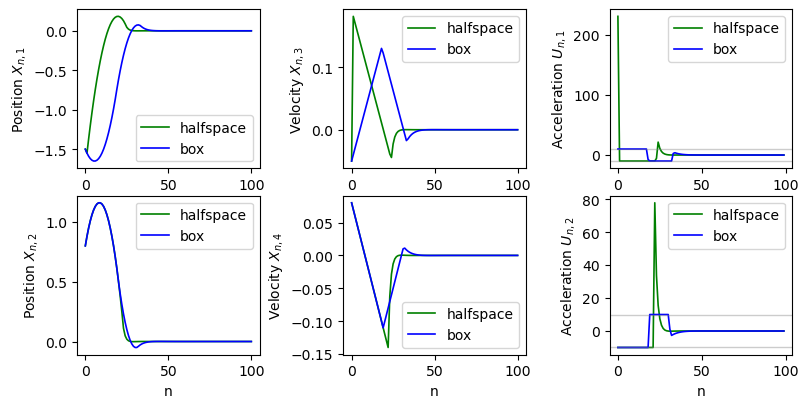

In [27]:
plt.figure(figsize=(8,4))
plt.tight_layout()
plt.subplots_adjust(wspace=0.2,hspace=0.1)
colors =['g','b']
labels =["halfspace","box"]
plt.subplot(2,3,1)
plt.plot(all_m_Xs[0,:,0],label=labels[0],color=colors[0],linewidth=1.2)
plt.plot(all_m_Xs[1,:,0],label=labels[1],color=colors[1],linewidth=1.2)
plt.ylabel(r"Position $X_{n,1}$")
plt.legend()
plt.subplot(2,3,2)
plt.plot(all_m_Xs[0,:,2],label=labels[0],color=colors[0],linewidth=1.2)
plt.plot(all_m_Xs[1,:,2],label=labels[1],color=colors[1],linewidth=1.2)
plt.ylabel(r"Velocity $X_{n,3}$")
plt.legend()
plt.subplot(2,3,3)
plt.plot(all_m_Us[0,:,0],label=labels[0],color=colors[0],linewidth=1.2)
plt.plot(all_m_Us[1,:,0],label=labels[1],color=colors[1],linewidth=1.2)
plt.axhline(y=-10, color='gray', linestyle='-',alpha=0.4,linewidth=1)
plt.axhline(y=10, color='gray', linestyle='-',alpha=0.4,linewidth=1)
plt.ylabel(r"Acceleration $U_{n,1}$")
plt.legend()

plt.subplot(2,3,4)
plt.plot(all_m_Xs[0,:,1],label=labels[0],color=colors[0],linewidth=1.2)
plt.plot(all_m_Xs[1,:,1],label=labels[1],color=colors[1],linewidth=1.2)
plt.ylabel(r"Position $X_{n,2}$")
plt.xlabel("n")
plt.legend()
plt.subplot(2,3,5)
plt.plot(all_m_Xs[0,:,3],label=labels[0],color=colors[0],linewidth=1.2)
plt.plot(all_m_Xs[1,:,3],label=labels[1],color=colors[1],linewidth=1.2)
plt.ylabel(r"Velocity $X_{n,4}$")
plt.xlabel("n")
plt.legend()
plt.subplot(2,3,6)
plt.plot(all_m_Us[0,:,1],label=labels[0],color=colors[0],linewidth=1.2)
plt.plot(all_m_Us[1,:,1],label=labels[1],color=colors[1],linewidth=1.2)
plt.axhline(y=-10, color='gray', linestyle='-',alpha=0.4,linewidth=1)
plt.axhline(y=10, color='gray', linestyle='-',alpha=0.4,linewidth=1)
plt.ylabel(r"Acceleration $U_{n,2}$")
plt.xlabel("n")
plt.legend()
plt.tight_layout(pad=0.4, w_pad=0.2, h_pad=0.1)
plt.savefig("linear_quadratic_constrained_control.png", dpi=300)